## Ансамбли. Бустинг

### ЗАДАНИЕ I. ДОПОЛНИТЕЛЬНОЕ

Дано: набор данных из системы поискового антиспама.

Требуется: сравнить классификаторы, основанные на алгоритмических композициях, с классическими алгоритмами классификации и нейросетями.

1. Скачать данные и запустить шаблон кода на python:

```
$ python compos.py -h
$ python compos.py -tr spam.train.txt -te spam.test.txt
```
2. Подобрать параметры трёх алгоритмических композиций, чтобы они превосходили по качеству SVM, логистическую регрессию и двуслойный персептрон.

3. Построить графики качества классификации в зависимости от числа базовых моделей.

In [1]:
!python compos.py -h
!python compos.py -tr spam.train.txt -te spam.test.txt

usage: compos.py [-h] [-tr TRAIN] [-te TEST] [-t TREES] [-fp FEATURES_PERCENT]

Random Forest Tutorial

optional arguments:
  -h, --help            show this help message and exit
  -tr TRAIN, --train TRAIN
                        Train file name
  -te TEST, --test TEST
                        Test file name
  -t TREES, --trees TREES
                        Number of trees in random forest
  -fp FEATURES_PERCENT, --features_percent FEATURES_PERCENT
                        Percent of features in each tree
Build random forest classifier...
Build adaboost classifier...
Build gbm classifier...
Build svm classifier...
Random Forest :
             precision    recall  f1-score   support

        0.0    0.57718   0.75406   0.65387      2033
        1.0    0.93243   0.86003   0.89477      8023

avg / total    0.86061   0.83860   0.84607     10056
final score    0.75481   0.80704   0.77432     10056

AdaBoost :
             precision    recall  f1-score   support

        0.0    0.92398   0.424

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression

In [3]:
train_data = np.loadtxt("spam.train.txt")
test_data  = np.loadtxt("spam.test.txt")

X_train, y_train = train_data[0::, 1::], train_data[0::, 0]
X_test, y_test = test_data[0::, 1::], test_data[0::, 0]

In [4]:
X_train.shape

(7093, 102)

In [5]:
svm_classifier = svm.SVC()
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)
f1_score(y_test, y_pred)

0.9585241566148487

In [6]:
logreg_classifier = LogisticRegression()
logreg_classifier.fit(X_train, y_train)
y_pred = logreg_classifier.predict(X_test)
f1_score(y_test, y_pred)

/Users/anastasiabogatenkova/miniconda3/envs/sphere/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9354754098360656

In [48]:
import torch
from torch.nn import MSELoss, Linear, Sigmoid, Module

class Net(Module):
    def __init__(self, activation=Sigmoid(), latent_size=100):
        super().__init__()
        self.fc1 = Linear(102, latent_size)
        self.fc2 = Linear(latent_size, 1)
        self.activation = activation
    def forward(self, x):
        return self.fc2(self.activation(self.fc1(x)))
    
def train(network, X_train, y_train, epochs=200, learning_rate=0.01, loss=MSELoss(), optim=torch.optim.Adam):
    optimizer = optim(network.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = network(X_train)
        loss_value = loss(y_pred, y_train)
        loss_value.backward()
        optimizer.step()

In [49]:
perceptron = Net()
train(perceptron, torch.from_numpy(X_train).float(), torch.from_numpy(y_train[:,np.newaxis]).float())
y_pred = perceptron(torch.from_numpy(X_test).float())
f1_score(y_test[:,np.newaxis], (y_pred.detach().numpy() > 0.5).astype(int))

0.940163132137031

In [69]:
params = list(range(50, 1001, 50)) # n_estimators

def tune_n_estimators(clf, X_train, y_train):
    best_n_estimators = params[0]
    res_score = 0
    scores = []

    for n_estimators in params:
        clf = clf.set_params(**{'n_estimators': n_estimators})
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = f1_score(y_test, y_pred)
        scores.append(score)
        if score > res_score:
            best_n_estimators = n_estimators
            res_score = score
    return scores, res_score, best_n_estimators

def make_plot(scores, clf_name):
    plt.figure(figsize=(15, 5))
    plt.title('Parameters tuning for ' + clf_name)
    plt.xlabel('n_estimators')
    plt.ylabel('F1-score')
    plt.tick_params(axis='x', labelrotation=90)
    plt.plot(params, scores)

F1-score=0.9679426141052497, n_estimators=900


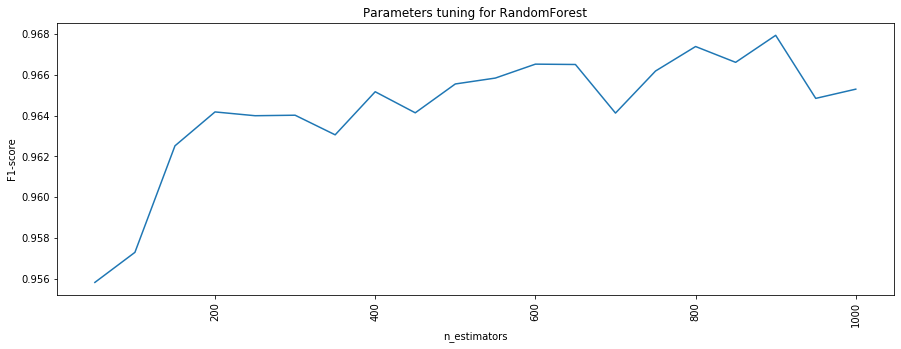

In [70]:
forest = RandomForestClassifier()
scores, res_score, best_n_estimators = tune_n_estimators(forest, X_train, y_train)
print(f'F1-score={res_score}, n_estimators={best_n_estimators}')
make_plot(scores, 'RandomForest')

F1-score=0.9599457727384767, n_estimators=150


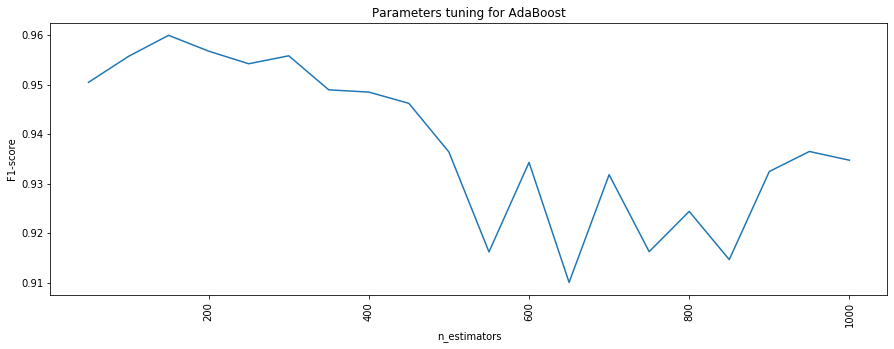

In [71]:
adaboost_classifier = AdaBoostClassifier()
scores, res_score, best_n_estimators = tune_n_estimators(adaboost_classifier, X_train, y_train)
print(f'F1-score={res_score}, n_estimators={best_n_estimators}')
make_plot(scores, 'AdaBoost')

F1-score=0.975473107569721, n_estimators=250


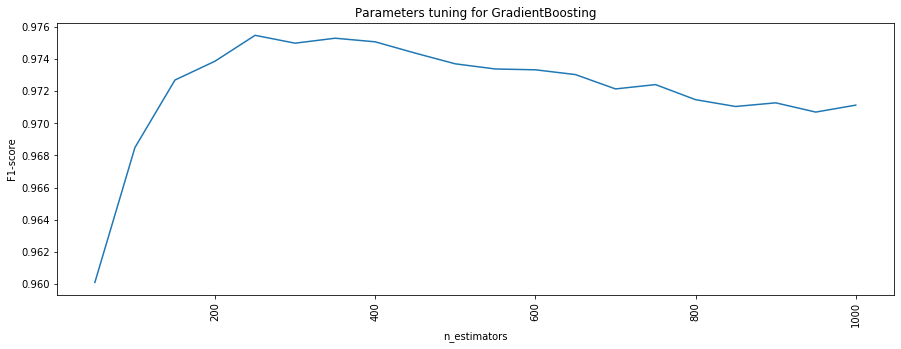

In [72]:
gbm_classifier = GradientBoostingClassifier()
scores, res_score, best_n_estimators = tune_n_estimators(gbm_classifier, X_train, y_train)
print(f'F1-score={res_score}, n_estimators={best_n_estimators}')
make_plot(scores, 'GradientBoosting')

### ЗАДАНИЕ II. ОСНОВНОЕ

Что необходимо сделать: реализовать один из алгоритмов машинного обучения, являющегося композицией алгоритмов.

In [8]:
def ComputeMyTaskNumber(your_name):
    return 1 + hash(your_name) % 21
ComputeMyTaskNumber('Bogatenkova_Anastasiya')

7

7. Реализация алгоритма BagBoo. В качестве базового алгоритма использовать алгоритм градиентного бустинга с логистической функцией потерь.